In [1]:
# Description: Plot Figure 2 (example of the Adaptive Filtering method on ADCP along-beam velocity data).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from xarray import open_dataset
from dewaveADCP.AdaptiveFiltering import bvelAF
from cmocean.cm import balance
from pandas import Timestamp, Timedelta
from pyspec.spectrum import block_avg, yNlu

In [3]:
def spec_error(E,sn,ci=.95):

    """ Computes confidence interval for one-dimensional spectral
        estimate E.

        Parameters
        ===========
        - sn is the number of spectral realizations;
                it can be either an scalar or an array of size(E)
        - ci = .95 for 95 % confidence interval

        Output
        ==========
        lower (El) and upper (Eu) bounds on E """

    dbin = .005
    yN = np.arange(0,2.+dbin,dbin)

    El, Eu = np.empty_like(E), np.empty_like(E)

    yNl,yNu = yNlu(sn,yN=yN,ci=ci)
    El = E/yNl
    Eu = E/yNu

    return El, Eu


def block_avgz(A, dts, Nblks):
    nz, nt = A.shape
    for k in range(nz):
        a = A[k, :]
        fg = np.isfinite(a)
        if not fg.any():
            if k==0:
                if not a.size%2:
                    siz = a.size/2/Nblks + 1
                else:
                    siz = a.size/2/Nblks
                S = np.ones(int(siz))*np.nan
            else:
                S = np.vstack((S, Saa.f*np.nan))
            continue
        a[~fg] = np.nanmean(a)
        Saa, nblks = block_avg(a, dts, N=Nblks);
        if k==0:
            S = Saa.spec
        else:
            S = np.vstack((S, Saa.spec[np.newaxis, ...]))
    f = Saa.f

    dof = 2*nblks
    return f, dof, np.nanmean(S, axis=0)

In [4]:
plt.close('all')

dtens_min = 10 # [min], length of ensemble.
freq = 8 # [Hz].
dr = 0.5 # [m].
max_badfrac = 0.5

Lw = 8
sep = 4

N = int(freq*60*dtens_min)

In [5]:
head = "../../data_reproduce_figs/"
ds = open_dataset(head+"OC25M-Ad2beam_beam1-5min.nc")
dss = open_dataset(head+"OC25M-Ad2beam_beam1-1day.nc")

In [6]:
t, z = ds['t'].values, ds['z'].values
b1 = ds['b1'].T.interpolate_na("z").values
b1s = dss['b1'].T.interpolate_na("z").values

In [7]:
# De-wave along-beam velocity.
b1dw = bvelAF(b1, sep=sep, Lw=Lw, verbose=False, max_badfrac=max_badfrac)
b1sdw = bvelAF(b1s, sep=sep, Lw=Lw, verbose=False, max_badfrac=max_badfrac)

In [8]:
dt = Timedelta("5 min")
tl = Timestamp('2017-10-22 04:00:00')
tr = tl + dt

In [9]:
dsstress = open_dataset(head+"OC25M-Ad1rs5-10min_ensembles-nobinmap.nc")
tlstress, trstress = Timestamp('2017-09-15 00:00:00'), Timestamp('2017-09-19 00:00:00')
dsstress = dsstress.sel(dict(t=slice(tlstress, trstress)))

tstress = dsstress['t']
zstress = dsstress['z']
z0 = 12.5 # [zab]
uwraw = dsstress['uwraw'].sel(dict(z=z0), method='nearest')
uwdw = dsstress['uwnotilt'].sel(dict(z=z0), method='nearest')
vwraw = dsstress['vwraw'].sel(dict(z=z0), method='nearest')
vwdw = dsstress['vwnotilt'].sel(dict(z=z0), method='nearest')

In [10]:
rsmin, rsmax = -1e-3, 1e-3 # [m2/s2].
bmin, bmax = -0.4, 0.4 # [m/s].
figsize = (8, 10)


# Depth-averaged spectra of along-beam velocities (prior to and after dewaving).

Nblks = 12
f, dof, Sbb = block_avgz(b1s, 1/freq/60, Nblks) # [cpmin].
f, dof, Sbbdw = block_avgz(b1sdw, 1/freq/60, Nblks) # [cpmin].

alpha = 0.95
Elbb, Eubb = spec_error(Sbb, dof//2, ci=alpha)
Elbbdw, Eubbdw = spec_error(Sbbdw, dof//2, ci=alpha)

<ipython-input-11-ddad33417d6c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs0 = ax[0].pcolormesh(t, z, b1, vmin=bmin, vmax=bmax, cmap=balance)
<ipython-input-11-ddad33417d6c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs1 = ax[1].pcolormesh(t, z, b1dw, vmin=bmin, vmax=bmax, cmap=balance)


Text(0, 0.5, 'PSD [(m/s)$^2$/cpmin]')

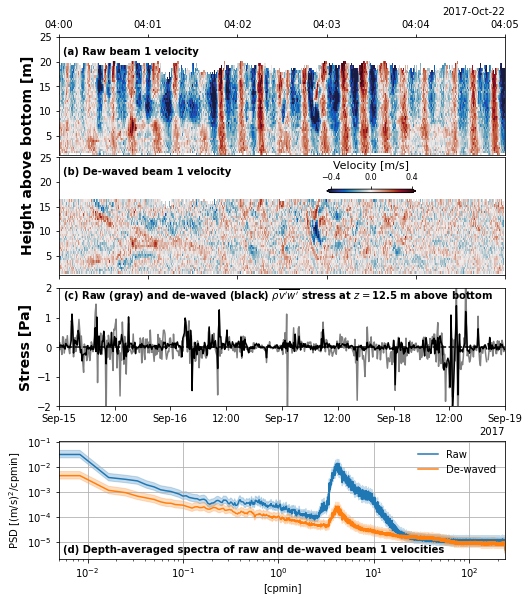

In [11]:
# Plotting.
fig, ax = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=figsize)
cs0 = ax[0].pcolormesh(t, z, b1, vmin=bmin, vmax=bmax, cmap=balance)
cs1 = ax[1].pcolormesh(t, z, b1dw, vmin=bmin, vmax=bmax, cmap=balance)

bbox = ax[0].get_position()
offset = -0.03
ax[0].set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

bbox = ax[2].get_position()
offset = 0.015
ax[2].set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

ax[0].xaxis.set_ticks_position('top')
ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticks_position('bottom')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(formatter)
ta = Timestamp(t[0])
if ta.month==9:
    mo = 'Sep'
elif ta.month==10:
    mo = 'Oct'
# dateannot = "%d-%s-%d"%(ta.year, mo, ta.day)
# ax[0].text(0.03, 1.05, dateannot, fontweight='black', transform=ax[0].transAxes, fontsize=12)

# Colorbar.
caxx, caxy = 0.60, 0.70
cbaxes = ax[1].inset_axes([caxx, caxy, 0.20, 0.03])

cb = fig.colorbar(mappable=cs0, cax=cbaxes, orientation='horizontal', extend='both')
cb.set_ticks([bmin, 0, bmax])
cb.ax.xaxis.set_tick_params(labelsize=8)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_label(r"Velocity [m/s]", fontsize=11)

# Wavy and de-waved stresses at mid-depth.
fac = 1024
ax[2].plot(tstress, vwraw*fac, color='gray', alpha=1)
ax[2].plot(tstress, vwdw*fac, color='k', alpha=1)
ax[2].axhline(color='k', linestyle='--')

ax[0].set_ylabel(r"Height above bottom [m]", fontsize=14, fontweight='black', y=0)
ax[2].set_ylabel(r"Stress [Pa]", fontsize=14, fontweight='black')

ax[0].set_xlim(tl, tr)
ax[1].set_xlim(tl, tr)
ax[2].set_xlim(tlstress, trstress)
ax[2].set_ylim(rsmin*fac, rsmax*fac)
ax[2].set_ylim(-2, 2)

locator = mdates.AutoDateLocator()
fmts = ['', '%Y', '%Y', '%Y', '%Y', '%Y %H:%M']
formatter = mdates.ConciseDateFormatter(locator, offset_formats=fmts)
ax[2].xaxis.set_major_locator(locator)
ax[2].xaxis.set_major_formatter(formatter)

ax[0].text(0.01, 0.85, r"(a) Raw beam 1 velocity", fontweight='bold', transform=ax[0].transAxes)
ax[1].text(0.01, 0.85, r"(b) De-waved beam 1 velocity", fontweight='bold', transform=ax[1].transAxes)
ax[2].text(0.01, 0.90, r"(c) Raw (gray) and de-waved (black) $\rho\overline{v'w'}$ stress at $z = $%.1f m above bottom"%z0, fontweight='black', transform=ax[2].transAxes)
ax[3].text(0.01, 0.05, r"(d) Depth-averaged spectra of raw and de-waved beam 1 velocities", fontweight='bold', transform=ax[3].transAxes)

l1 = ax[3].loglog(f, Sbb, label=r"Raw")
l2 = ax[3].loglog(f, Sbbdw, label=r"De-waved")
ax[3].yaxis.set_ticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

ax[3].fill_between(f, Elbb, y2=Eubb, color=l1[0].get_color(), alpha=0.25)
ax[3].fill_between(f, Elbbdw, y2=Eubbdw, color=l2[0].get_color(), alpha=0.25)

ax[3].set_xlim(right=f[-1])
ax[3].grid()
ax[3].legend(frameon=False)
ax[3].set_xlabel("[cpmin]")
ax[3].set_ylabel("PSD [(m/s)$^2$/cpmin]")

In [12]:
fig.savefig("fig02.png", dpi=300, bbox_inches='tight')
plt.show()